## GSE129843 – Time-restricted feeding alters lipid and amino acid metabolite rhythmicity – skeletal muscle

- In muscle, 4-10% of transcripts and 14% of metabolites were periodic
- Core clock genes were unaltered by either intervention, while time-restricted feeding induced rhythmicity of genes related to lipid and amino acid transport
- Time-restricted feeding shifted the skeletal muscle metabolite profile from predominantly lipids to amino acids.
- two experimental dietary conditions – 11 overweight/obese men
- https://pmc.ncbi.nlm.nih.gov/articles/PMC7495469/


In [2]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
from pydeseq2.preprocessing import deseq2_norm

### Step 1: Open the dataset

In [4]:
path = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt/rnaseq_datasets/GSE129843_rnaseq.h5ad'
adata = ad.read_h5ad(path)

#Transform to DataFrame
data_df = pd.DataFrame(data=adata.X, columns=adata.var.index, index=adata.obs.index).T

#Look at dataset
adata.var[['diet', 'time', 'subject']]
data_df

GeneID,100287102,653635,102466751,107985730,100302278,645520,79501,100996442,729737,102725121,...,4538,4564,4575,4568,4540,4541,4556,4519,4576,4571
GSM3723230,4,203,5,1,0,0,0,11,7,3,...,4536,396,241,32,2295,491,168,4945,342,18585
GSM3723231,3,124,3,0,0,0,0,10,8,2,...,3292,194,115,17,1527,243,94,3656,217,11301
GSM3723232,2,190,2,1,0,0,0,12,3,1,...,1890,394,294,26,1150,278,253,2938,324,21568
GSM3723233,5,252,2,1,0,0,0,45,40,3,...,4906,367,215,31,2271,447,252,5599,743,46720
GSM3723234,3,148,2,0,0,0,0,37,51,1,...,1043,112,84,12,683,135,73,1564,120,6180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3723350,8,137,2,0,0,0,0,16,26,6,...,3818,298,213,24,1710,331,173,4820,304,15174
GSM3723351,8,168,3,0,0,0,0,23,24,7,...,2641,489,417,35,1655,372,320,4824,391,31686
GSM3723352,4,118,2,0,0,0,0,9,6,8,...,3588,149,105,21,1775,357,154,4448,344,15311
GSM3723353,3,84,1,0,0,0,0,12,9,2,...,2228,588,449,25,850,174,203,3160,511,40073


### Step 2: Prepare the dataset

In [15]:
data_df_norm = deseq2_norm(data_df)[0]
data_df_log = np.log10(data_df_norm + 0.1) #Logarithmic transformation

### Step 3: Exploratory analysis

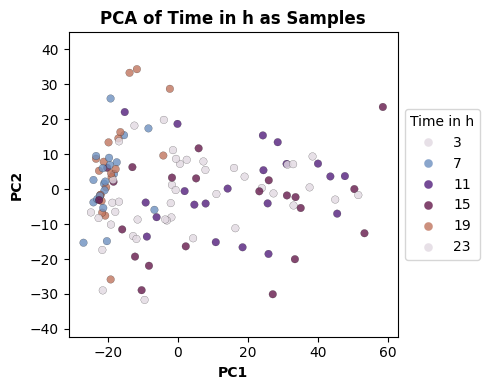

In [6]:
data_df_log_time = data_df_log.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=data_df_log_time, label='Time in h', c_map='twilight')

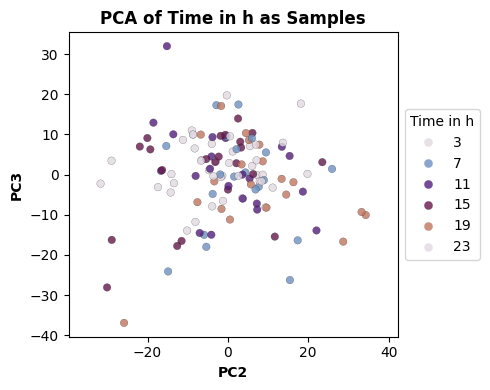

In [7]:
pc.principal_component_2d_timesample(data=data_df_log_time, x=2, y=3, label='Time in h', c_map='twilight')

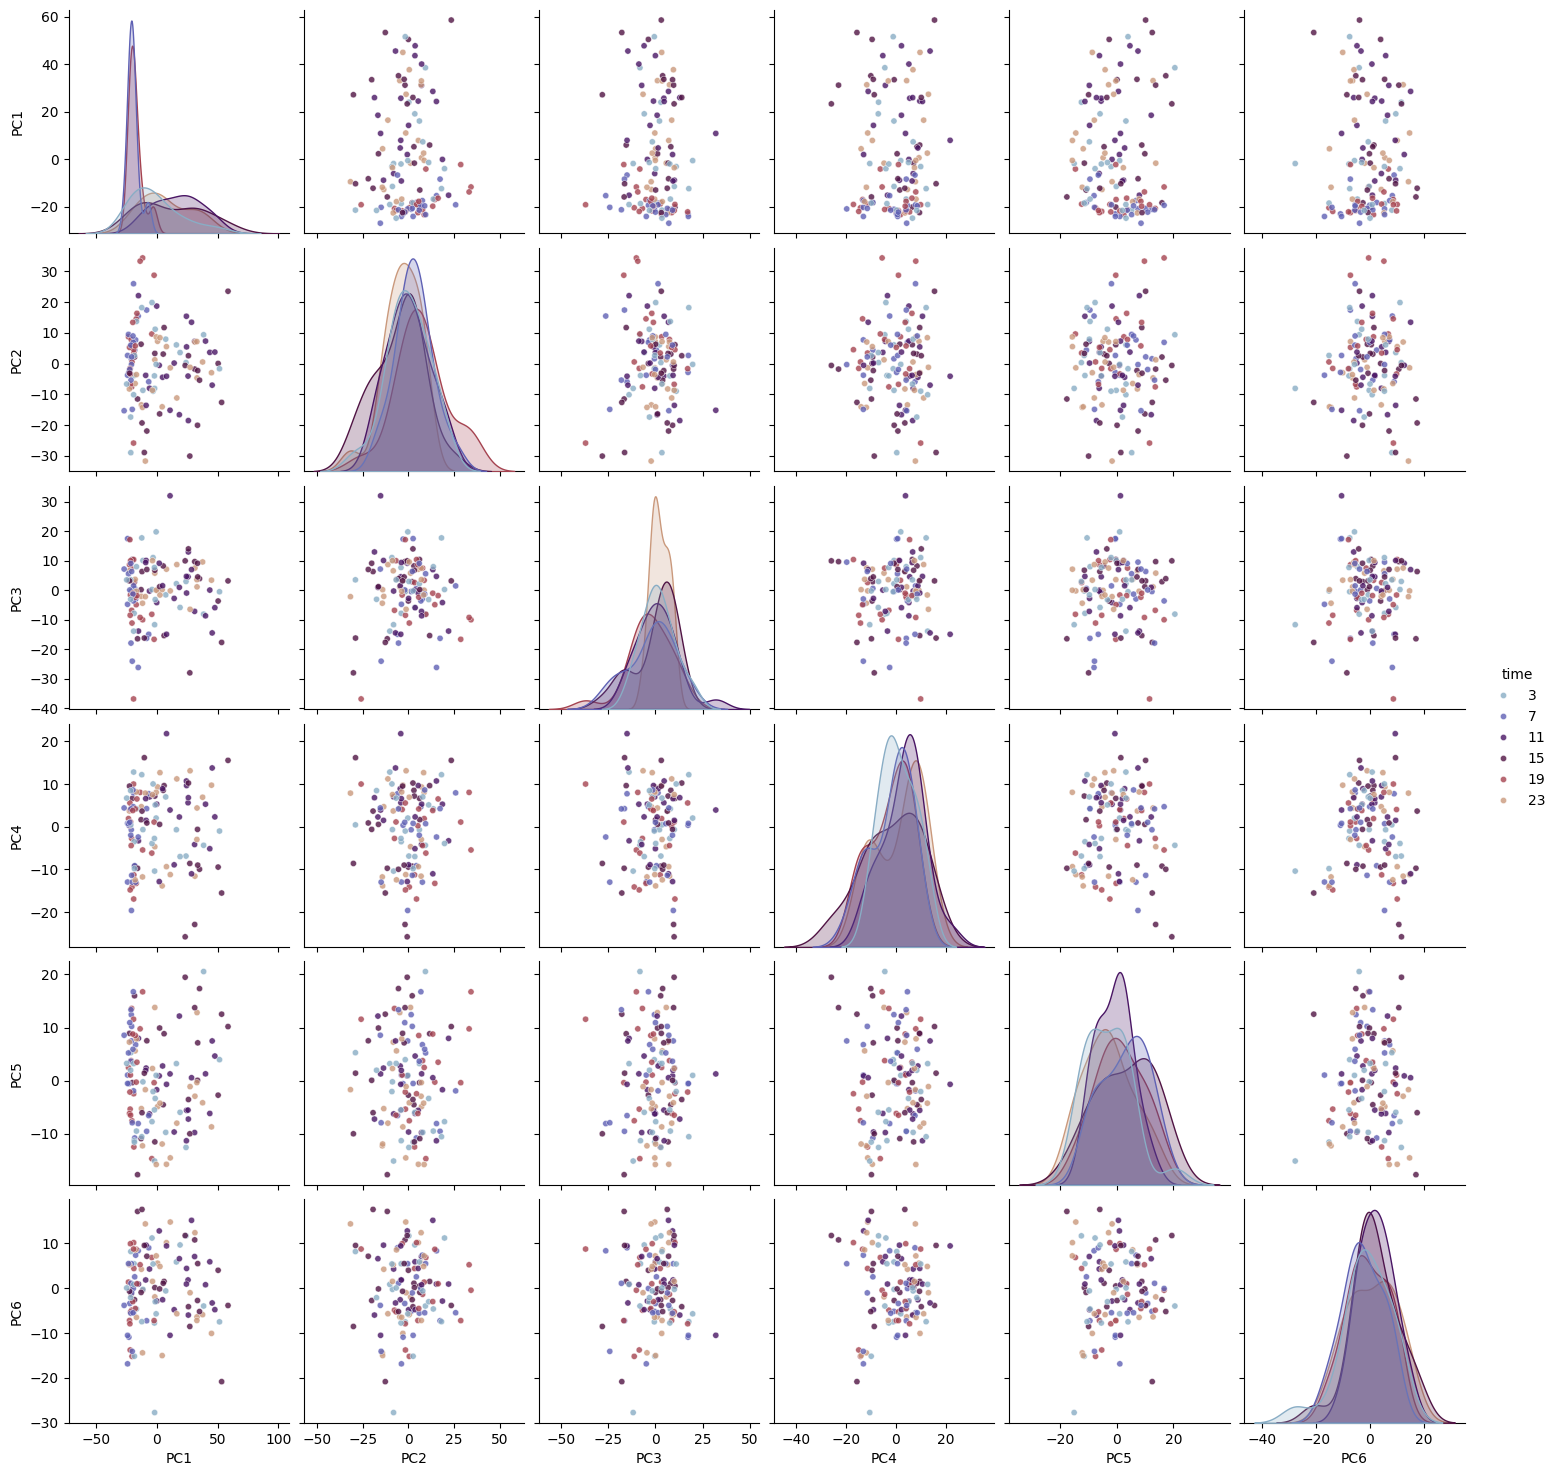

In [8]:
pc.pairplot_psa_6(data=data_df_log_time, palette='twilight')

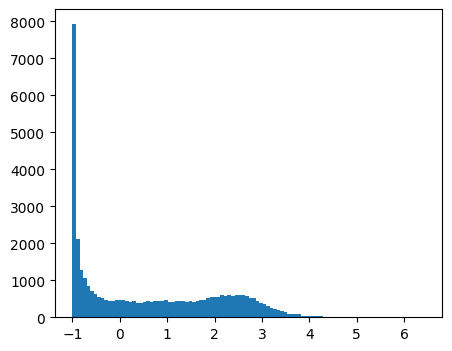

In [9]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.mean(), bins=100);

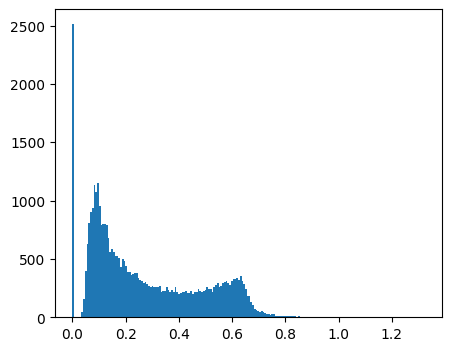

In [10]:
plt.figure(figsize=(5, 4))
plt.hist(x=data_df_log.std(), bins=200);

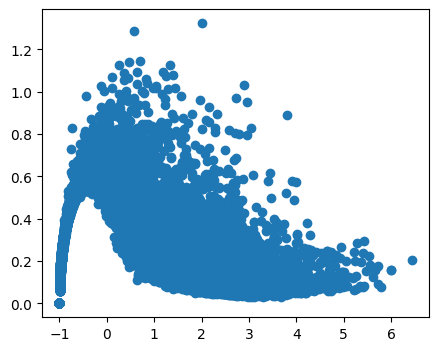

In [11]:
plt.figure(figsize=(5, 4))
plt.scatter(x=data_df_log.mean(), y=data_df_log.std());

### Step 4: Batch Effects

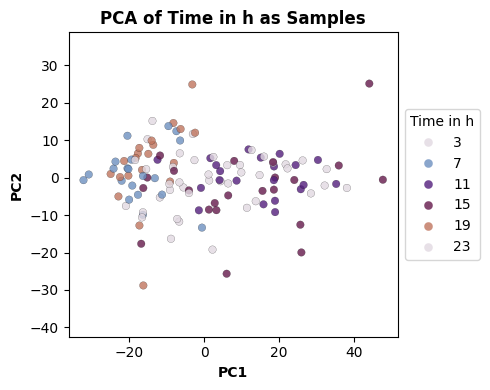

In [12]:

residual_0 = pc.residual_dummy(data=data_df_log.T[data_df_log.mean() >0].T, data_dummy_1=adata.var['diet'], columns=['diet'])
residual_1 = pc.residual_dummy(data=residual_0, data_dummy_1=adata.var['subject'], columns=['subject'])
residual_time = residual_1.join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.principal_component_2d_timesample(data=residual_time, label='Time in h', c_map='twilight')

### Step 5: COFE

### All samples

In [16]:
X_train_a = data_df_log
true_time_train_a = adata.var['time'].astype(int)

X_train_a, X_test_a, features_a, features_std_a = COFE.analyse.preprocess_data(X_train_a.to_numpy(), None, 
                                                                           features=X_train_a.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_a.shape # (Samples, Transcripts)

(125, 7004)

In [17]:
s_choices = np.linspace(1, 50, 15)
cv_a = COFE.analyse.cross_validate(X_train_a, s_choices, features=features_a, K=5, ncores=-1)

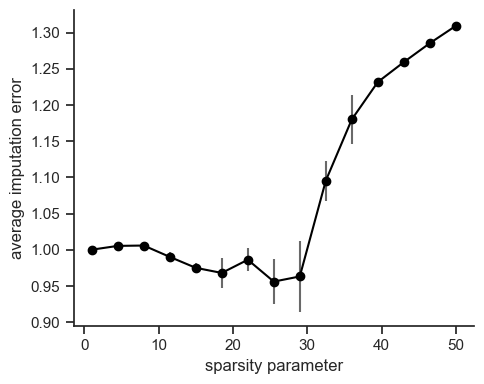

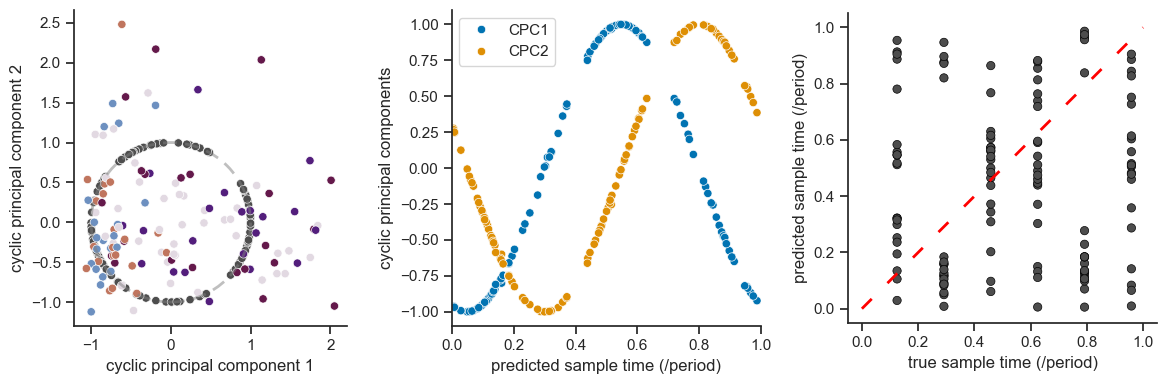

In [18]:
results_train_diet_a = COFE.analyse.predict_time(X_train_a, cv_a, true_times=true_time_train_a.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_a, time=true_time_train_a.to_numpy(), X=X_train_a, figsize=(12, 4))

### Reduction of Batch Effects

##### Differences in Feeding

In [21]:
X_train_residual_a = residual_0
true_time_train_residual_a = adata.var['time'].astype(int)

X_train_residual_a, X_test_residual_a, features_residual_a, features_std_residual_a = COFE.analyse.preprocess_data(X_train_residual_a.to_numpy(), None, 
                                                                           features=X_train_residual_a.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=5)
X_train_residual_a.shape # (Samples, Transcripts)

(125, 8461)

In [22]:
s_choices_residual = np.linspace(1, 50, 15)
cv_a_residual = COFE.analyse.cross_validate(X_train_residual_a, s_choices_residual, features=features_residual_a, K=5, ncores=-1)

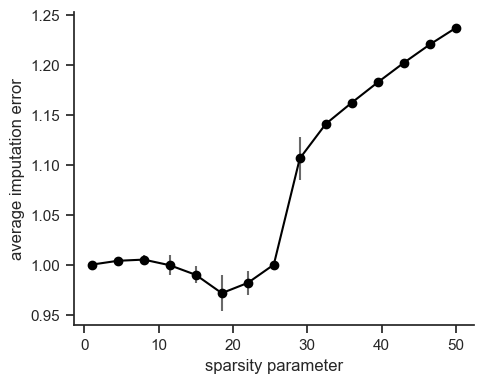

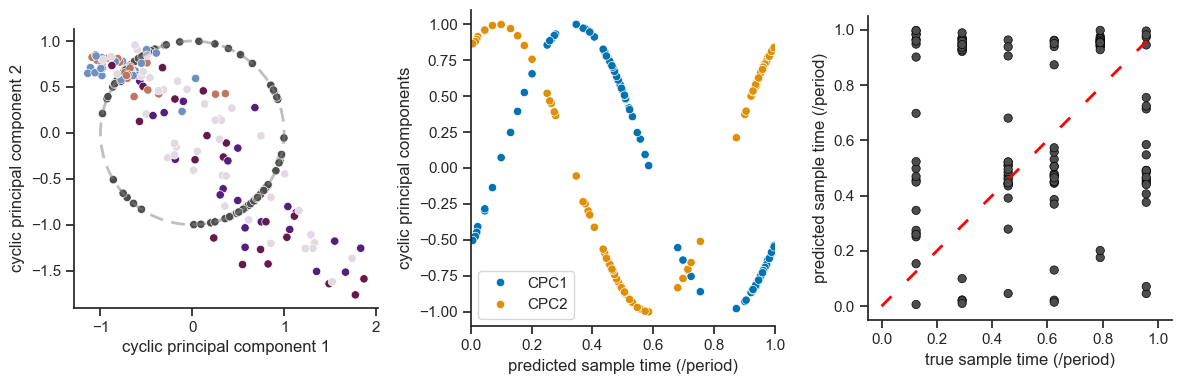

In [23]:
results_train_diet_residual_a = COFE.analyse.predict_time(X_train_residual_a, cv_a_residual, true_times=true_time_train_residual_a.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_residual_a, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_residual_a, time=true_time_train_residual_a.to_numpy(), X=X_train_residual_a, figsize=(12, 4))

##### Differences in Feeding and Subjects

In [25]:
X_train_residual_b = residual_1
true_time_train_residual_b = adata.var['time'].astype(int)

X_train_residual_b, X_test_residual_b, features_residual_b, features_std_residual_b = COFE.analyse.preprocess_data(X_train_residual_b.to_numpy(), None, 
                                                                           features=X_train_residual_b.columns, feature_dim='col',
                                                                           mean_threshold=-1, scaling_threshold=6)
X_train_residual_b.shape # (Samples, Transcripts)

(125, 8718)

In [26]:
s_choices_residual = np.linspace(1, 50, 15)
cv_b_residual = COFE.analyse.cross_validate(X_train_residual_b, s_choices_residual, features=features_residual_b, K=5, ncores=-1)

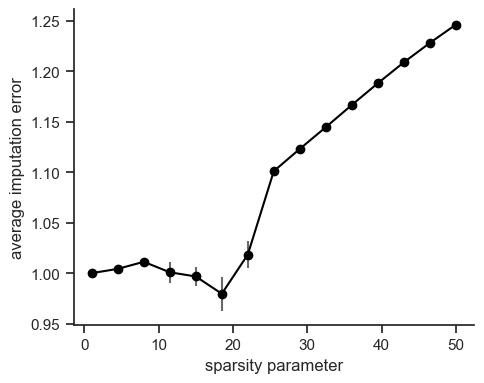

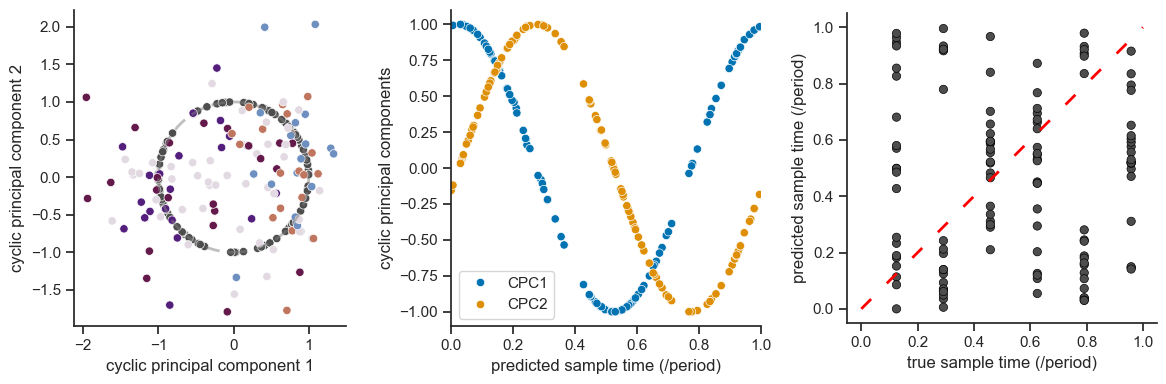

In [27]:
results_train_diet_residual_b = COFE.analyse.predict_time(X_train_residual_b, cv_b_residual, true_times=true_time_train_residual_b.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_residual_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_residual_b, time=true_time_train_residual_b.to_numpy(), X=X_train_residual_b, figsize=(12, 4))

### Only Time-Restricted Feeding

In [28]:
X_train_b = data_df_log[adata.var['diet'] == 'Time restricted']
true_time_train_b = adata.var[adata.var['diet'] == 'Time restricted']['time'].astype(int)

X_train_b, X_test_b, features_b, features_std_b = COFE.analyse.preprocess_data(X_train_b.to_numpy(), None, 
                                                                           features=X_train_b.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_b.shape # (Samples, Transcripts)

(63, 6932)

In [29]:
s_choices = np.linspace(1, 70, 15)
cv_b = COFE.analyse.cross_validate(X_train_b, s_choices, features=features_b, K=5, ncores=-1)

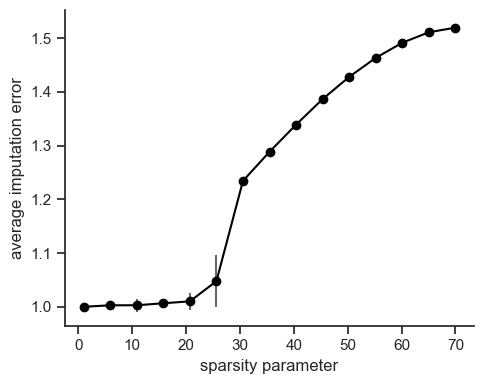

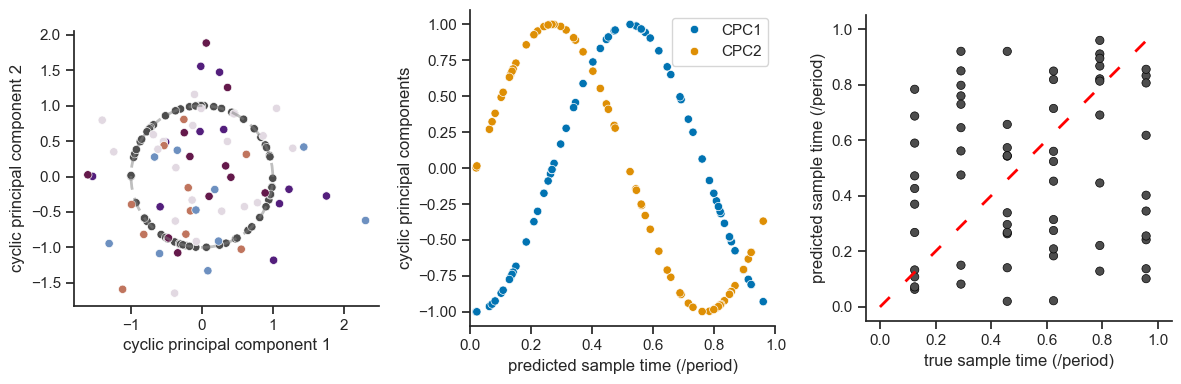

In [30]:
results_train_diet_b = COFE.analyse.predict_time(X_train_b, cv_b, true_times=true_time_train_b.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_b, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_b, time=true_time_train_b.to_numpy(), X=X_train_b, figsize=(12, 4))

In [31]:
results_train_diet_b["MAPE"]*24

np.float64(4.774393580477856)

### Only Extended Feeding

In [32]:
X_train_c = data_df_log[adata.var['diet'] == 'Unrestricted']
true_time_train_c = adata.var[adata.var['diet'] == 'Unrestricted']['time'].astype(int)

X_train_c, X_test_c, features_c, features_std_c = COFE.analyse.preprocess_data(X_train_c.to_numpy(), None, 
                                                                           features=X_train_c.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=8)
X_train_c.shape # (Samples, Transcripts)

(62, 7006)

In [33]:
s_choices = np.linspace(1, 70, 15)
cv_c = COFE.analyse.cross_validate(X_train_c, s_choices, features=features_c, K=5, ncores=-1)

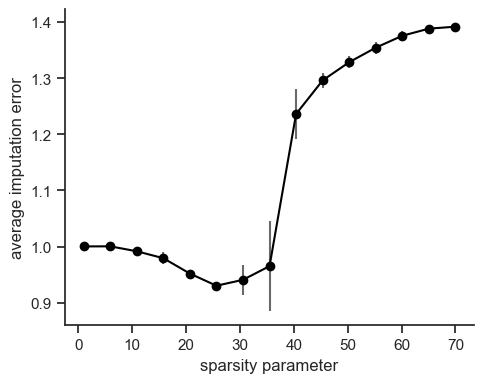

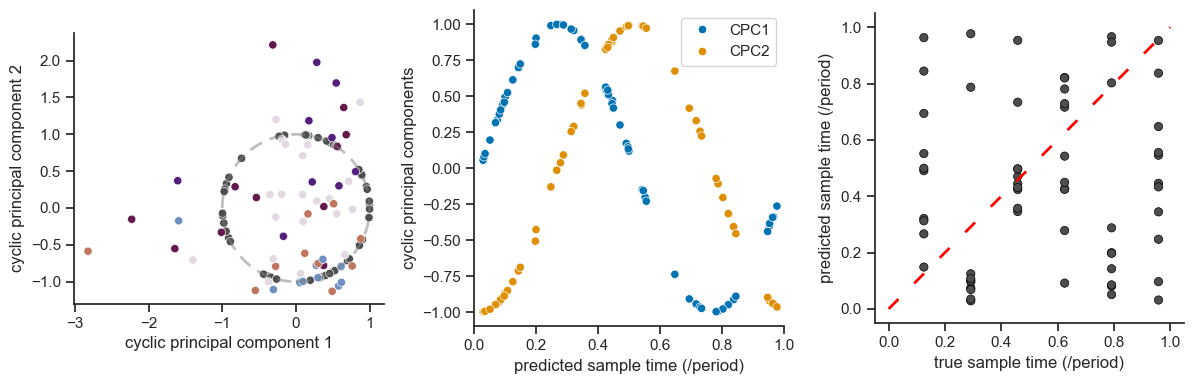

In [34]:
results_train_diet_c = COFE.analyse.predict_time(X_train_c, cv_c, true_times=true_time_train_c.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_c, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_c, time=true_time_train_c.to_numpy(), X=X_train_c, figsize=(12, 4))

#### Strongly Reduced

In [35]:
X_train_d = data_df_log[adata.var['diet'] == 'Unrestricted']
true_time_train_d = adata.var[adata.var['diet'] == 'Unrestricted']['time'].astype(int)

X_train_d, X_test_d, features_d, features_std_d = COFE.analyse.preprocess_data(X_train_d.to_numpy(), None, 
                                                                           features=X_train_d.columns, feature_dim='col',
                                                                           mean_threshold=1, scaling_threshold=6)
X_train_d.shape # (Samples, Transcripts)

(62, 4233)

In [36]:
s_choices = np.linspace(1, 50, 15)
cv_d = COFE.analyse.cross_validate(X_train_d, s_choices, features=features_d, K=5, ncores=-1)

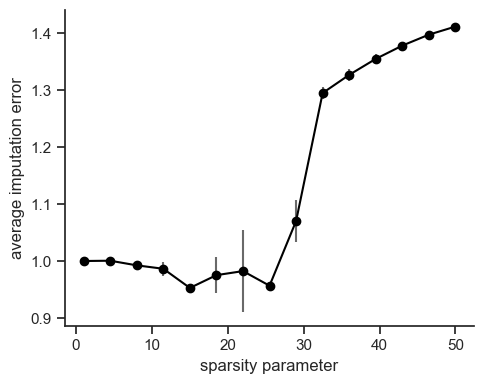

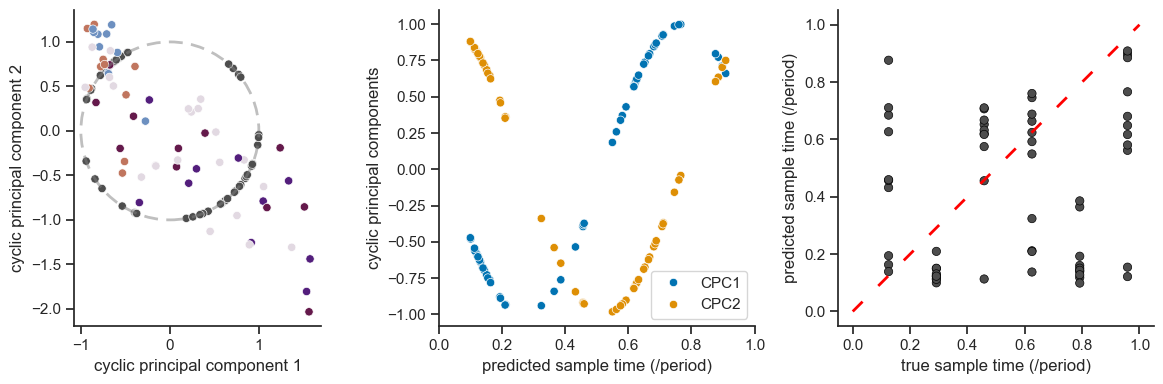

In [37]:
results_train_diet_d = COFE.analyse.predict_time(X_train_d, cv_d, true_times=true_time_train_d.to_numpy())
COFE.plot.plot_cv_run(results_train_diet_d, figsize=(5,4))
COFE.plot.plot_circular_ordering(results_train_diet_d, time=true_time_train_d.to_numpy(), X=X_train_d, figsize=(12, 4))

In [38]:
results_train_diet_d["MAPE"]*24

np.float64(4.680042886427191)

## Conclusion

COFE cannot predict sample time in muscle samples, probably because the researchers suspect that there are only 4-10% rhythmic transcripts, nevertheless there are rhythmic patterns present. The researchers also looked at PCA results in their paper and could not find any clustering or separation based on time, and they subsequently used t-SNE and saw separation of samples based on time, but already on the identified rhytmic transcripts. I regardless tried to use t-SNE and UMAP on unrestricted feeding samples to see if it they show better differentiation between time samples. As you can see below t-SNE and UMAP show more distinct result than PCA, but are more random.

#### t-SNE

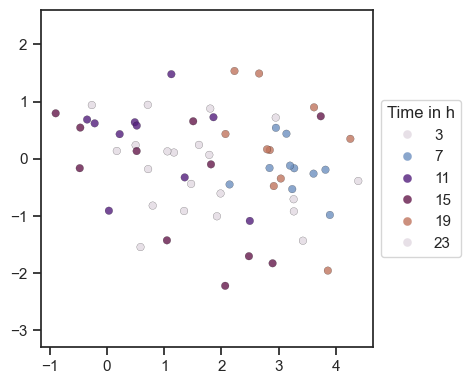

In [39]:
data_df_log_time_un = data_df_log[adata.var['diet'] == 'Unrestricted'].join(adata.var['time']).reset_index().set_index('time').drop('index', axis=1)
pc.visualization_of_dec_tools_2d(dec=TSNE(), data=data_df_log_time_un, label='Time in h', c_map='twilight')

### UMAP

/Users/maksimsgolubovics/Python_VScode/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


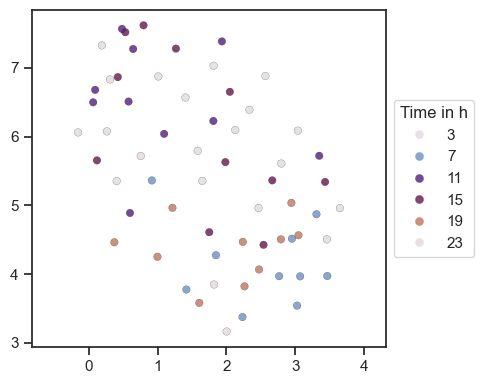

In [40]:
pc.visualization_of_dec_tools_2d(dec=UMAP(), data=data_df_log_time_un, label='Time in h', c_map='twilight')